In [1]:
!pip install /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl

Processing /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 KB 14.9 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.3 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# basic modules
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm
from datetime import datetime
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display

# pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision.transforms import Normalize
from torch.multiprocessing import Pool

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torch.optim import lr_scheduler
import torchvision.transforms as T

from timm.scheduler import CosineLRScheduler

from skimage.transform import resize

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import segmentation_models_pytorch as smp

In [5]:
import torch_xla
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp

In [6]:
base_dir = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/"
train_path = os.path.join(base_dir,"train")
test_path = os.path.join(base_dir,"test")
val_path = os.path.join(base_dir,"validation")

train_ids = os.listdir(train_path)
#train_ids = np.loadtxt("/kaggle/input/train-ids-existcontrail/train_ids_ExistContrail.csv", delimiter=",", dtype = "unicode")
#train_ids = train_ids.tolist()

test_ids = os.listdir(test_path)
val_ids = os.listdir(val_path)

In [7]:
def ash_transform(x, time_frame:int=4):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)
    if time_frame is not None:
        x = x[:,time_frame,:,:]
    def normalize_range(data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    r = normalize_range(x[2] - x[1], _TDIFF_BOUNDS)
    g = normalize_range(x[1] - x[0], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(x[1], _T11_BOUNDS)
    
    return np.clip(np.stack([r, g, b], axis=-3), 0, 1) # (T,3,H,W) or (3,H,W)

In [8]:
def random_horizontal_flip(video):
    horizontal = random.random()
    if horizontal < 0.5:
        return video[..., ::-1], horizontal
    return video, horizontal

def random_vertical_flip(video):
    vertical = random.random()
    if vertical < 0.5:
        return video[..., ::-1, :], vertical
    return video, vertical


def random_color(img, c=3): #(c, H, W)
    for i in range(c):
        bright_ratio = 0.01 * np.random.randint(75, 100)
        img[i] = bright_ratio * img[i]
    return img

def random_crop(img, output_size=(3, 256, 256)):
    c, h, w = img.shape #(c, H, W)

    # 元画像のアスペクト比を保持するために、クロップする正方形のサイズをランダムに選ぶ
    # ここでサイズを元の画像の50%から75%の範囲で選ぶ
    min_crop_size = int(min(h, w) * 0.70)
    max_crop_size = int(min(h, w) * 1.00)
    crop_size = np.random.randint(min_crop_size, max_crop_size)

    # 画像からクロップする部分の開始点（左上の座標）をランダムに選ぶ
    top = np.random.randint(0, h - crop_size)
    left = np.random.randint(0, w - crop_size)

    # その開始点から所定のサイズの部分をクロップ
    cropped_img = img[:, top: top + crop_size, left: left + crop_size]

    # scikit-imageのresize関数を使用して、クロップした画像を元のサイズにリサイズ
    # resize関数は (Height, Width, Channel) の順序を想定しているため、次元を並び替える
    resized_img = resize(np.transpose(cropped_img, (1, 2, 0)), output_size[1:], mode='reflect')

    # 最後に、元の次元の並び (Channel, Height, Width) に戻す
    resized_img = np.transpose(resized_img, (2, 0, 1))

    return resized_img, top, left, crop_size


def random_mask(img, mask_size=10, musk_num=20):
    i = 0
    for i in range(musk_num):
        if random.random() < 0.5:
            h, w = img.shape[-2:]
            top = random.randint(0, h - mask_size)
            left = random.randint(0, w - mask_size)
            img[..., top:top+mask_size, left:left+mask_size] = 0
            i += 1
    return img

def augment_video(video):
    #video = random_vertical_flip(video)  #正解データも反転させないとダメでは？
    #print(video.shape)
    video = np.stack([random_mask(frame) for frame in video.transpose(1, 0, 2, 3)])

    return video.transpose(1, 0, 2, 3)


# Test with dummy data
#video = np.random.rand(3, 10, 224, 224)
#augmented_video = augment_video(video)

In [9]:
class ContrailDataset(Dataset):
    def __init__(self, ids, base_dir, bands=None, transforms:list=[], test_mode:bool=False, aug=False):
        self.ids = ids
        self.base_dir = base_dir
        self.transforms = transforms
        self.bands = bands
        self.permute = (2,0,1)
        self.test_mode = test_mode
        self.aug = aug
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
    def __getitem__(self, index):
        record_id = self.ids[index]
        
        if self.bands is None:
            band_list = [f'band_{band:02d}.npy' for band in range(8,17)]
        else :
            band_list = [f'band_{int(band):02d}.npy' for band in self.bands]
        
        x = list()
        for band in band_list:
            x_path = os.path.join(self.base_dir, record_id, band)
            x.append(np.load(x_path).transpose(self.permute))

        x = np.stack(x,axis=1) ## X.shape = (Time_frame,channel,H,W)
        
        x = x.transpose((1,0,2,3)) ## PLUS ## X.shape = (channel, Time_frame ,H,W)
        
        #print(x.shape)
        
        for transformation in self.transforms:
            x = transformation(x)   # X.shape = (channel ,H,W)
             
        if self.aug: #aug would be applied only train-data which must be have target-data(y)
            #print(x.shape)
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = np.load(y_path).transpose(self.permute).astype(np.float32) #Y.shape = (channel ,H,W)
            
            x = np.concatenate((x, y), axis=0)
            x = random_mask(x) 
            y = x[3]
            y = np.expand_dims(y, axis=0)
            x = x[0:3]

            #x = random_mask(x)

            x = torch.from_numpy(x.astype(np.float32)).to(torch.float32)
            x = self.normalize_image(x)
            y = torch.from_numpy(y.astype(np.float32))
        
        if self.test_mode:
            x = torch.from_numpy(x.astype(np.float32)).to(torch.float32)
            x = self.normalize_image(x)
            return x
        
        elif self.aug:
            return x, y
        
        else:
            x = torch.from_numpy(x.astype(np.float32)).to(torch.float32)
            x = self.normalize_image(x)
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = torch.from_numpy(np.load(y_path).transpose(self.permute).astype(np.float32))

            return x, y

    def __len__(self):
        return len(self.ids)
        

In [10]:
os.cpu_count()

96

In [11]:
# Datasets 
dataset_params = {
    "bands" : [11,14,15], 
    "transforms" : [ash_transform]
}
train_dataset = ContrailDataset(train_ids, train_path, **dataset_params, aug=True)
test_dataset = ContrailDataset(test_ids, test_path, test_mode=True, **dataset_params)
val_dataset = ContrailDataset(val_ids, val_path, **dataset_params)

# DalaLoaders
dataloader_params = {
    "batch_size" : 16,
    "shuffle" : True,
    "num_workers": 20,
    "drop_last": True
#     "pin_memory": True

}
train_loader = DataLoader(train_dataset, **dataloader_params)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2)
val_loader = DataLoader(val_dataset, **dataloader_params)

In [12]:
def plot_contrail(x, y, time_frame = 4):
    '''
    x = false color img of shape (8, 3, H, W)
    y = contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(y.permute(1,2,0), interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

    plt.show()

def plot_contrail_comparision(x, y_true, y_pred, time_frame = 4):
    '''
    x = false color img of shape (3, H, W) or (8, 3, H, W)
    y_true = target contrail mask of shape (1, H, W)
    y_pred = predicted contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 5, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image(x)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 2)
    ax.imshow(y_true.permute(1,2,0), interpolation='none')
    ax.set_title('True contrail mask(y_true)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_true.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_true mask on x')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 4)
    ax.imshow(y_pred.permute(1,2,0), interpolation='none')
    ax.set_title('Pred contrail mask(y_pred)')
    ax.axis('off')

    ax = plt.subplot(1, 5, 5)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_pred.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_pred mask on x')
    ax.axis('off')
    
    plt.show()

def animate_contrail(x):
    '''
    x = false color img of shape (8, 3, H, W)
    '''
    if x.ndim !=4:
        print(f"Incorrect input dimensions, Expected 4 recievied {x.ndim}.")
        return
    # Animation
    fig = plt.figure(figsize=(4, 4))
    im = plt.imshow(x[0].permute(1,2,0))
    def draw(i):
        im.set_array(x[i].permute(1,2,0))
        return [im]
    anim = animation.FuncAnimation(
        fig, draw, frames=x.shape[0], interval=100, blit=True
    )
    plt.close()
    return display.HTML(anim.to_jshtml())

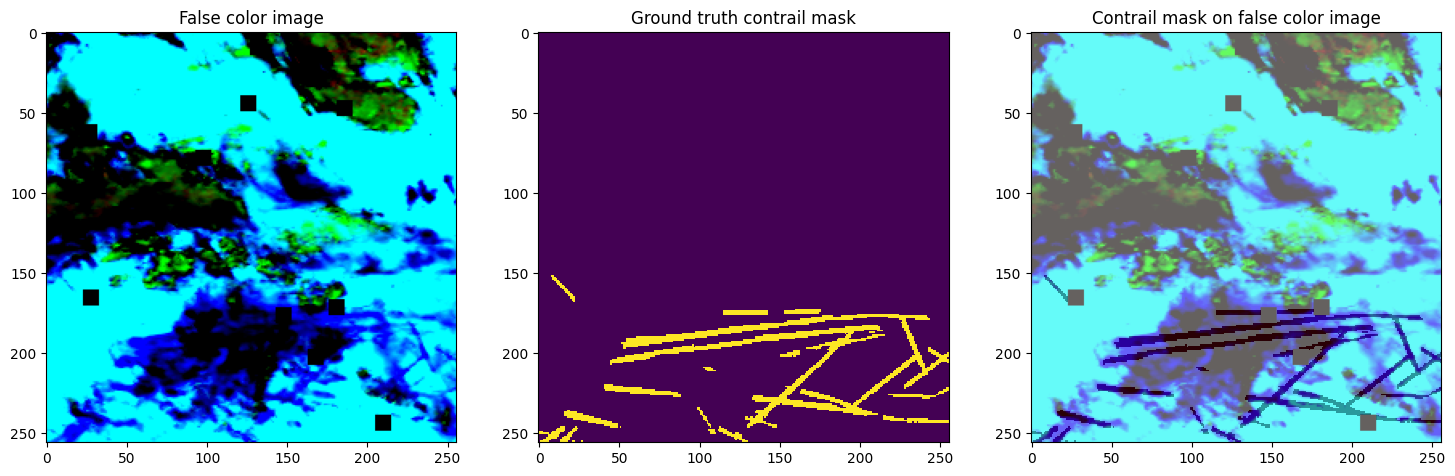

In [13]:
 x, y = train_dataset[train_ids.index('1704010292581573769')]
 plot_contrail(x, y)

In [14]:
# old type
'''# Dice Coefficient
def dice_coeff(mask1, mask2):
    intersect = torch.sum(mask1 * mask2)
    m1sum = torch.sum(mask1)
    m2sum = torch.sum(mask2)
    dice = (2 * intersect ) / (m1sum + m2sum)
    return dice.item()
'''

'# Dice Coefficient\ndef dice_coeff(mask1, mask2):\n    intersect = torch.sum(mask1 * mask2)\n    m1sum = torch.sum(mask1)\n    m2sum = torch.sum(mask2)\n    dice = (2 * intersect ) / (m1sum + m2sum)\n    return dice.item()\n'

In [15]:
def dice_coeff(y_p, y_t, smooth=1e-6):
    i = torch.sum(y_p * y_t, dim=(2, 3))
    u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(2, 3))
    score = (2 * i + smooth)/(u + smooth)
    dice = torch.mean(score)
    return dice.item()

In [16]:
def dice_global(y_p,y_t,smooth=1e-3):

    intersection = torch.sum(y_p * y_t)
    union = torch.sum(y_p) + torch.sum(y_t)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

def dice_loss_global(y_p,y_t):
    return 1-dice_global(y_p,y_t)

In [17]:
# Callbacks
class History:
    def __init__(self, print_prefix, save_to_disk=True):
        self.train_batch_history = []
        self.val_batch_histroy = []
        self.train_epoch_history = []
        self.val_epoch_history = []
        self.running_train_batch_history = []
        self.running_val_batch_history = []
        self.print_prefix = print_prefix
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states",self.print_prefix)
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)
    def on_train_batch_end(self, data):
        self.running_train_batch_history.append(data)
        
    def on_val_batch_end(self, data):
        self.running_val_batch_history.append(data)
        
    def on_epoch_end(self):
        self.train_epoch_history.append(np.mean(self.running_train_batch_history))
        self.train_batch_history.extend(self.running_train_batch_history)
        self.running_train_batch_history=[]
        self.val_epoch_history.append(np.mean(self.running_val_batch_history))
        self.val_batch_histroy.extend(self.running_val_batch_history)
        self.running_val_batch_history=[]
        print(f"{self.print_prefix}: Train = {self.train_epoch_history[-1]:.6f} \
        | Val = {self.val_epoch_history[-1]:.6f}")
    
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            np.save(os.path.join(self.save_path,"train_batch.npy"),self.train_batch_history)
            np.save(os.path.join(self.save_path,"val_batch.npy"),self.val_batch_histroy)
            np.save(os.path.join(self.save_path,"train_epoch.npy"),self.train_epoch_history)
            np.save(os.path.join(self.save_path,"val_epoch.npy"),self.val_epoch_history)

In [18]:
class BestStateTracker:
    def __init__(self, model, optim, trigger:History, save_to_disk:bool = False):
        self.trigger = trigger
        self.model = model
        self.optim = optim
        self.optim_state = None
        self.model_state = None
        self.best_loss = np.inf
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states")
            if not os.path.exists(self.save_path):
                os.mkdir(self.save_path)
                
    def on_epoch_end(self):
        if self.trigger.val_epoch_history[-1] < self.best_loss:
            self.model_state = self.model.state_dict()
            self.optim_state = self.optim.state_dict()
            
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            xm.save(self.model_state,os.path.join(self.save_path,f"model_state_end.pt"))
            xm.save(self.optim_state,os.path.join(self.save_path,f"optim_state_end.pt"))

In [19]:
device = xm.xla_device()

E0618 18:05:37.734363162     383 oauth2_credentials.cc:236]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {created_time:"2023-06-18T18:05:37.73434526+00:00", grpc_status:2}


In [20]:
ENCODER = 'timm-efficientnet-b1' #'resnet101''timm-efficientnet-b4'
ENCODER_WEIGHTS = 'noisy-student' #'imagenet''noisy-student'

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

'''model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)'''

'model = smp.DeepLabV3Plus(\n    encoder_name=ENCODER, \n    encoder_weights=ENCODER_WEIGHTS, \n    classes=1, \n    activation=ACTIVATION,\n).to(device)'

In [21]:
model.load_state_dict(torch.load("/kaggle/input/2dunet-b11-normalized-10epoch/model_state_2DUnet-b1_Normalized b1 10Epoch.pt",map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [22]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
      super(Focal_MultiLabel_Loss, self).__init__()
      self.gamma = gamma
      self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets): 
      bce = self.bceloss(outputs, targets)
      bce_exp = torch.exp(-bce)
      focal_loss = 1 * (1-bce_exp)**self.gamma * bce
      return focal_loss.mean()

In [23]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [24]:
class LogCoshDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LogCoshDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        x = 1 - dice #diceloss
        
        return torch.log((torch.exp(x) + torch.exp(-x)) / 2.0)

In [25]:
!mkdir /kaggle/working/model

In [26]:
LR = 0.000125 #2e-3
EPOCHS = 10

FLAGS={}
FLAGS['num_cores'] = 8
FLAGS['start_epoch'] = 0
FLAGS['num_epochs'] = EPOCHS
FLAGS['num_workers'] = 12
FLAGS['log_steps'] = 100
FLAGS['seed'] = 123
FLAGS['max_lr'] = LR
FLAGS['min_lr'] = 0.00004
FLAGS['warmup_steps'] = 0

In [27]:
optimizer = Adam(params=model.parameters(), lr=LR)
#loss_fn = BCELoss()
loss_fn_1 = BCELoss()
loss_fn_2 = Focal_MultiLabel_Loss(gamma=2) 
loss_fn_3 = DiceLoss()
loss_fn_4 = LogCoshDiceLoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=2)
'''scheduler = CosineLRScheduler(optimizer, 
                              t_initial=EPOCHS, 
                              lr_min=FLAGS['min_lr'], 
                              warmup_t=FLAGS['warmup_steps'],
                              warmup_lr_init=5e-6,
                              warmup_prefix=True)'''

loss_tracker = History(print_prefix="Loss")
dice_tracker = History(print_prefix="Dice")
save_state = BestStateTracker(model,optimizer,loss_tracker,save_to_disk=True)

In [28]:
WRAPPED_MODEL = xmp.MpModelWrapper(model)


def _map_fn(index, flags):
  pbar = tqdm(range(flags['start_epoch'], flags['num_epochs']))
  loss_best = 1.0
  torch.manual_seed(flags['seed'])

  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler=train_sampler,
    num_workers=flags['num_workers'],
    drop_last=True)
  
  val_sampler = torch.utils.data.distributed.DistributedSampler(
    val_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)

  val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 16,
    sampler=val_sampler,
    num_workers=flags['num_workers'],
    drop_last=False)

  for epoch in range(flags['start_epoch'], flags['num_epochs']):
    current_lr = optimizer.param_groups[0]['lr']
    xm.master_print(f"EPOCH: {epoch+1}/{flags['num_epochs']}, Learning rate: {current_lr}")
    para_train_loader = pl.ParallelLoader(train_loader, [device])
    model.train()
    
    for idx, (data, target) in enumerate(para_train_loader.per_device_loader(device)):
      y_pred = model(data)
      loss2 = loss_fn_2(y_pred, target) #Focal
      loss4 = loss_fn_4(y_pred, target) #DICE
      #loss4 = dice_loss_global(y_pred, target) #GlobalDICELoss
      loss  = 0.2 * loss2 + 0.8 * loss4
      optimizer.zero_grad()
      loss.backward()
      xm.optimizer_step(optimizer)
      
      if idx % flags['log_steps'] == 0:
        xm.master_print(f'Train Batch: {idx+1}/{len(train_loader)} | Loss: {loss.item():.6f}')
        xm.master_print(f'FOCAL_Loss: {loss2.item():.6f}')
        xm.master_print(f'LogCoshDICE_Loss: {loss4.item():.6f}')
        
      loss_tracker.on_train_batch_end(loss.item())
      dice_tracker.on_train_batch_end(dice_coeff(y_pred>0.5, target))
      #pbar.set_description(f"Train Batch: {idx+1}/{len(train_loader)}\
      #| Loss: {loss.item():.6f}")

    plot_contrail_comparision(data[0].cpu().detach(),
                           target[0].cpu().detach(),
                           y_pred[0].cpu().detach()>0.5)
      
    model.eval()
    para_val_loader = pl.ParallelLoader(val_loader, [device])
    
    with torch.no_grad():
        for idx, (data, target) in enumerate(para_val_loader.per_device_loader(device)):
            y_pred = model(data)
            #loss =  loss_fn_3(y_pred, target) # Only DiceLoss for Validation
            loss = dice_loss_global(y_pred, target)
            loss_tracker.on_val_batch_end(loss.item())
            dice_tracker.on_val_batch_end(dice_coeff(y_pred>0.5, target))
            #pbar.set_description(f"Val Batch:   {idx+1}/{len(val_loader)}\
            #| Loss: {loss.item():.6f}")
            if idx % flags['log_steps'] == 0:
                xm.master_print(f'Val Batch: {idx+1}/{len(val_loader)} | GlobalDICELoss: {loss.item():.6f}')
                
        plot_contrail_comparision(data[0].cpu().detach(),
                        target[0].cpu().detach(),
                        y_pred[0].cpu().detach()>0.5)
    
                
    #xm.save(model.state_dict(), flags['save_path'])    
    scheduler.step(epoch)
    loss_tracker.on_epoch_end()
    dice_tracker.on_epoch_end()
    save_state.on_epoch_end()

  save_state.on_end()
  loss_tracker.on_end()
  dice_tracker.on_end()

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10, Learning rate: 0.000125
Train Batch: 1/1283 | Loss: 0.050007
FOCAL_Loss: 0.026962
LogCoshDICE_Loss: 0.055768
Train Batch: 101/1283 | Loss: 0.073743
FOCAL_Loss: 0.030540
LogCoshDICE_Loss: 0.084544
Train Batch: 201/1283 | Loss: 0.062115
FOCAL_Loss: 0.019561
LogCoshDICE_Loss: 0.072754
Train Batch: 301/1283 | Loss: 0.055862
FOCAL_Loss: 0.022602
LogCoshDICE_Loss: 0.064177
Train Batch: 401/1283 | Loss: 0.044864
FOCAL_Loss: 0.022034
LogCoshDICE_Loss: 0.050571
Train Batch: 501/1283 | Loss: 0.052708
FOCAL_Loss: 0.011722
LogCoshDICE_Loss: 0.062954
Train Batch: 601/1283 | Loss: 0.044165
FOCAL_Loss: 0.015720
LogCoshDICE_Loss: 0.051276
Train Batch: 701/1283 | Loss: 0.033987
FOCAL_Loss: 0.009054
LogCoshDICE_Loss: 0.040220
Train Batch: 801/1283 | Loss: 0.063998
FOCAL_Loss: 0.045029
LogCoshDICE_Loss: 0.068740
Train Batch: 901/1283 | Loss: 0.057948
FOCAL_Loss: 0.024646
LogCoshDICE_Loss: 0.066273
Train Batch: 1001/1283 | Loss: 0.043647
FOCAL_Loss: 0.012846
LogCoshDICE_Loss: 0.051348
Train B

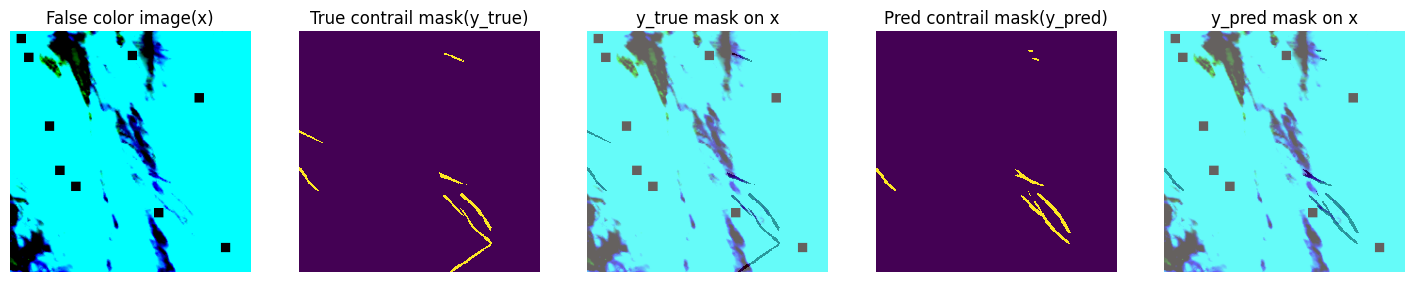

Val Batch: 1/116 | GlobalDICELoss: 0.390249
Val Batch: 101/116 | GlobalDICELoss: 0.370475


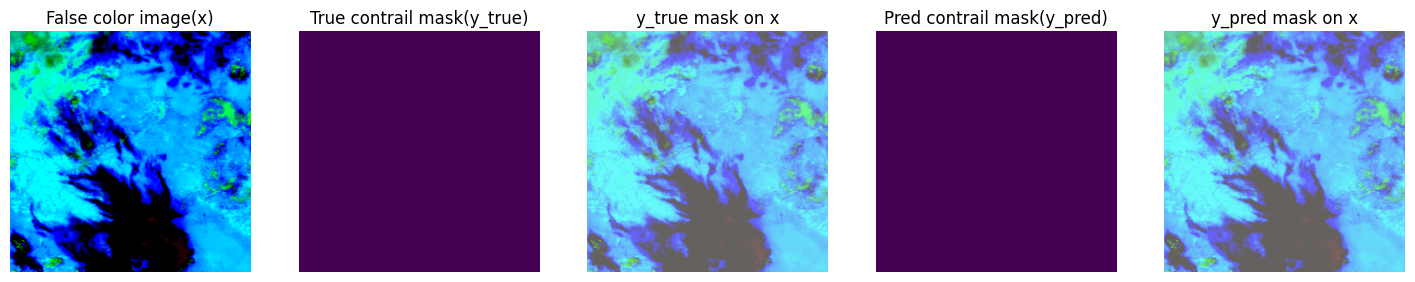

Loss: Train = 0.053614         | Val = 0.451655
Dice: Train = 0.751844         | Val = 0.791273
EPOCH: 2/10, Learning rate: 0.000125
Train Batch: 1/1283 | Loss: 0.049788
FOCAL_Loss: 0.026572
LogCoshDICE_Loss: 0.055592
Train Batch: 101/1283 | Loss: 0.091239
FOCAL_Loss: 0.031982
LogCoshDICE_Loss: 0.106053
Train Batch: 201/1283 | Loss: 0.060309
FOCAL_Loss: 0.018605
LogCoshDICE_Loss: 0.070735
Train Batch: 301/1283 | Loss: 0.049131
FOCAL_Loss: 0.020132
LogCoshDICE_Loss: 0.056381
Train Batch: 401/1283 | Loss: 0.043775
FOCAL_Loss: 0.022089
LogCoshDICE_Loss: 0.049197
Train Batch: 501/1283 | Loss: 0.055834
FOCAL_Loss: 0.012151
LogCoshDICE_Loss: 0.066755
Train Batch: 601/1283 | Loss: 0.040512
FOCAL_Loss: 0.015069
LogCoshDICE_Loss: 0.046873
Train Batch: 701/1283 | Loss: 0.033627
FOCAL_Loss: 0.010022
LogCoshDICE_Loss: 0.039528
Train Batch: 801/1283 | Loss: 0.061669
FOCAL_Loss: 0.043321
LogCoshDICE_Loss: 0.066256
Train Batch: 901/1283 | Loss: 0.059260
FOCAL_Loss: 0.022527
LogCoshDICE_Loss: 0.068443

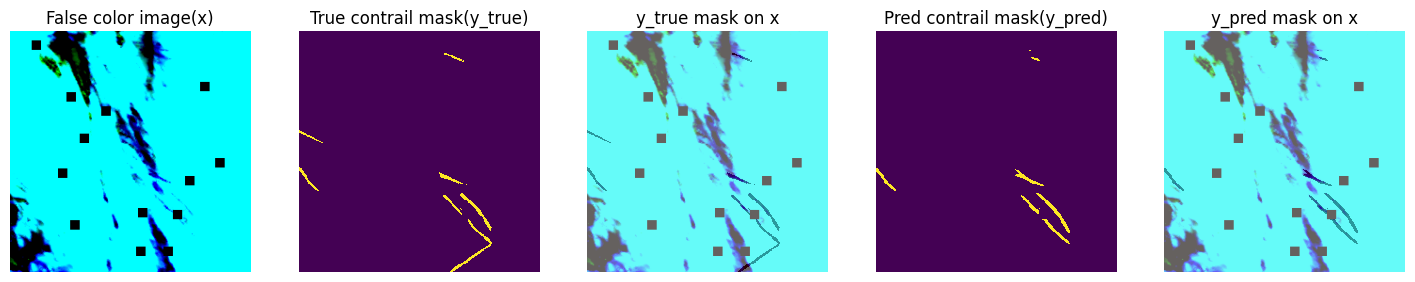

Val Batch: 1/116 | GlobalDICELoss: 0.392527
Val Batch: 101/116 | GlobalDICELoss: 0.397950


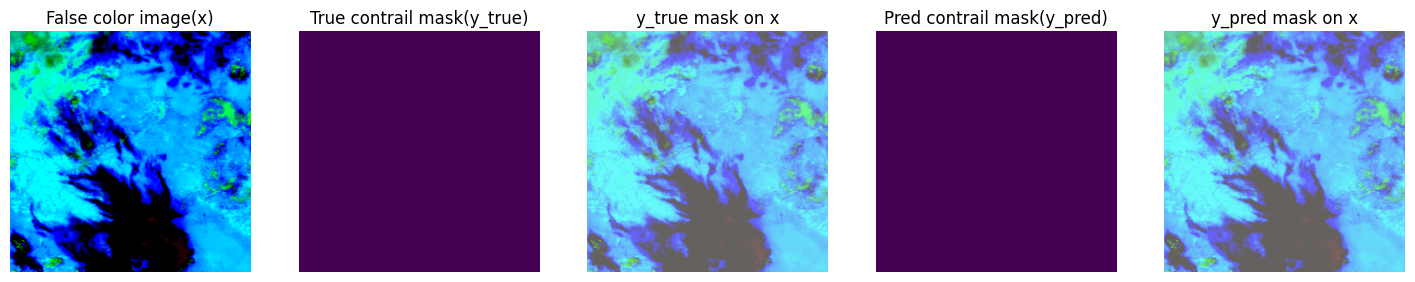

Loss: Train = 0.052771         | Val = 0.451698
Dice: Train = 0.753167         | Val = 0.791532
EPOCH: 3/10, Learning rate: 0.000125
Train Batch: 1/1283 | Loss: 0.059582
FOCAL_Loss: 0.026522
LogCoshDICE_Loss: 0.067848
Train Batch: 101/1283 | Loss: 0.079157
FOCAL_Loss: 0.028897
LogCoshDICE_Loss: 0.091722
Train Batch: 201/1283 | Loss: 0.056152
FOCAL_Loss: 0.018336
LogCoshDICE_Loss: 0.065606
Train Batch: 301/1283 | Loss: 0.048316
FOCAL_Loss: 0.019799
LogCoshDICE_Loss: 0.055446
Train Batch: 401/1283 | Loss: 0.044716
FOCAL_Loss: 0.021739
LogCoshDICE_Loss: 0.050460
Train Batch: 501/1283 | Loss: 0.057660
FOCAL_Loss: 0.012550
LogCoshDICE_Loss: 0.068937
Train Batch: 601/1283 | Loss: 0.045733
FOCAL_Loss: 0.016295
LogCoshDICE_Loss: 0.053093
Train Batch: 701/1283 | Loss: 0.028371
FOCAL_Loss: 0.008531
LogCoshDICE_Loss: 0.033332
Train Batch: 801/1283 | Loss: 0.059818
FOCAL_Loss: 0.042137
LogCoshDICE_Loss: 0.064239
Train Batch: 901/1283 | Loss: 0.063570
FOCAL_Loss: 0.025121
LogCoshDICE_Loss: 0.073183

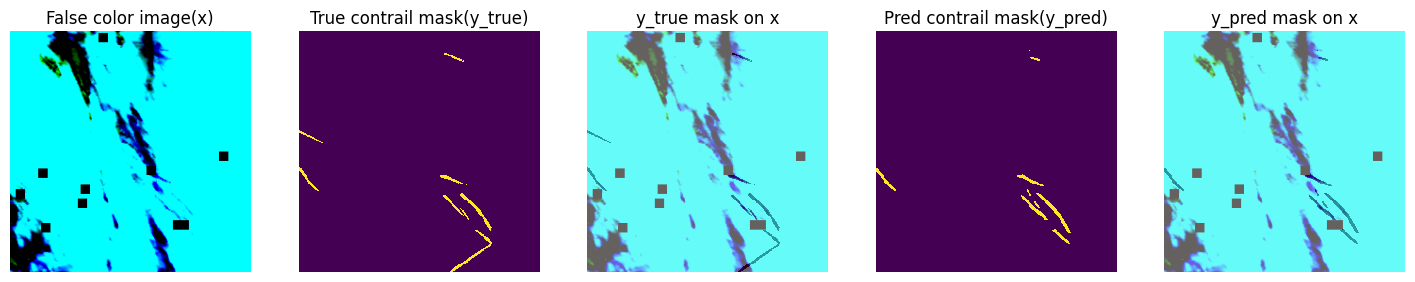

Val Batch: 1/116 | GlobalDICELoss: 0.367041
Val Batch: 101/116 | GlobalDICELoss: 0.375035


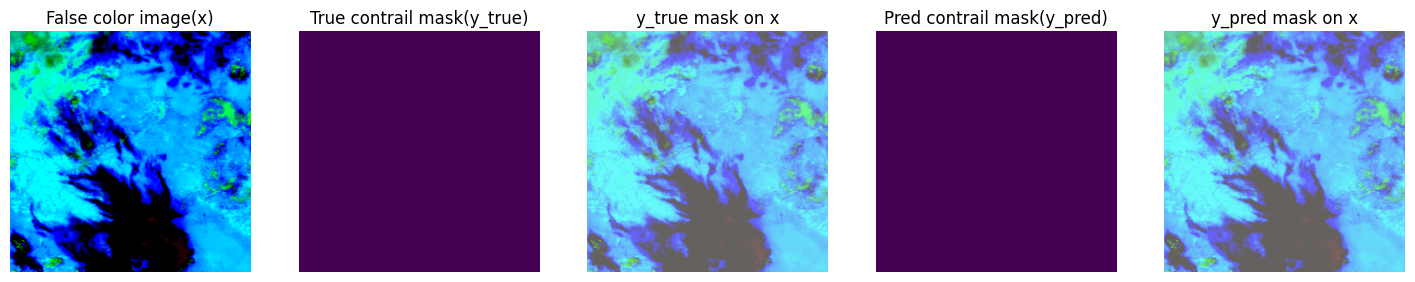

Loss: Train = 0.052128         | Val = 0.448722
Dice: Train = 0.756974         | Val = 0.787523
EPOCH: 4/10, Learning rate: 0.000125
Train Batch: 1/1283 | Loss: 0.050611
FOCAL_Loss: 0.027338
LogCoshDICE_Loss: 0.056429
Train Batch: 101/1283 | Loss: 0.073168
FOCAL_Loss: 0.027968
LogCoshDICE_Loss: 0.084468
Train Batch: 201/1283 | Loss: 0.056231
FOCAL_Loss: 0.018014
LogCoshDICE_Loss: 0.065785
Train Batch: 301/1283 | Loss: 0.054247
FOCAL_Loss: 0.021207
LogCoshDICE_Loss: 0.062507
Train Batch: 401/1283 | Loss: 0.044907
FOCAL_Loss: 0.022180
LogCoshDICE_Loss: 0.050589
Train Batch: 501/1283 | Loss: 0.055396
FOCAL_Loss: 0.012215
LogCoshDICE_Loss: 0.066191
Train Batch: 601/1283 | Loss: 0.041175
FOCAL_Loss: 0.015723
LogCoshDICE_Loss: 0.047539
Train Batch: 701/1283 | Loss: 0.028848
FOCAL_Loss: 0.008468
LogCoshDICE_Loss: 0.033943
Train Batch: 801/1283 | Loss: 0.062357
FOCAL_Loss: 0.044814
LogCoshDICE_Loss: 0.066743
Train Batch: 901/1283 | Loss: 0.055209
FOCAL_Loss: 0.023677
LogCoshDICE_Loss: 0.063093

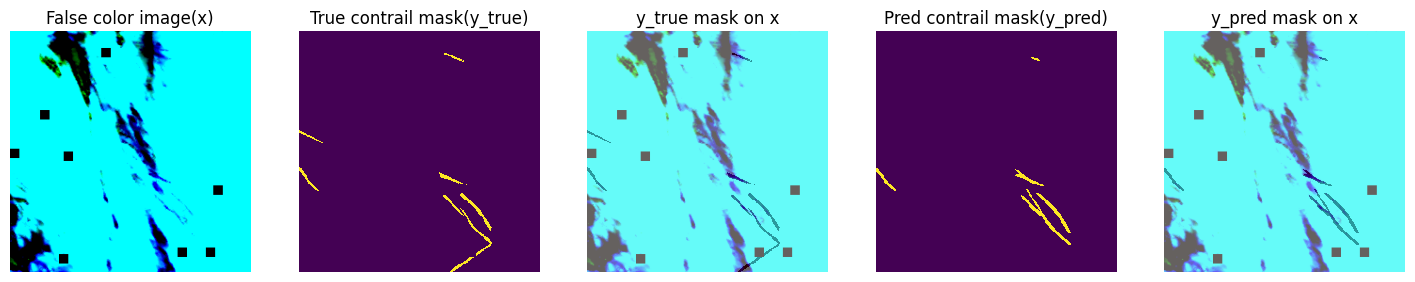

Val Batch: 1/116 | GlobalDICELoss: 0.386733
Val Batch: 101/116 | GlobalDICELoss: 0.386313


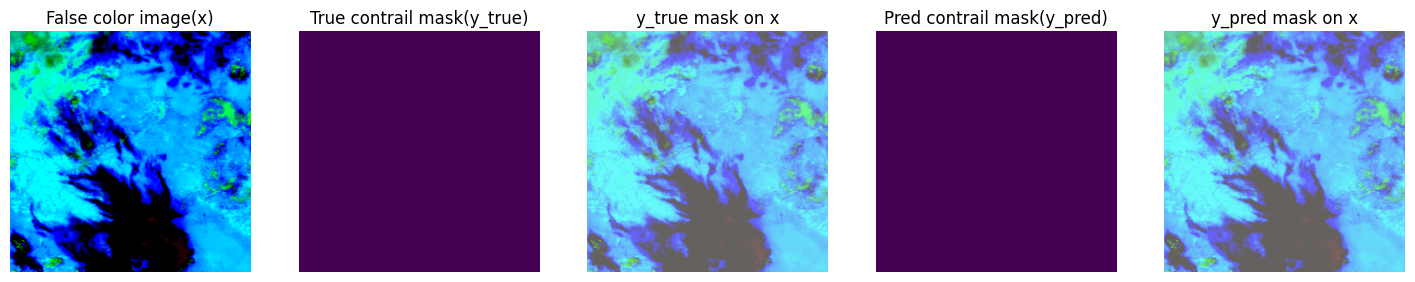

Loss: Train = 0.051513         | Val = 0.450244
Dice: Train = 0.758384         | Val = 0.791512
EPOCH: 5/10, Learning rate: 3.125e-05
Train Batch: 1/1283 | Loss: 0.050124
FOCAL_Loss: 0.027060
LogCoshDICE_Loss: 0.055891
Train Batch: 101/1283 | Loss: 0.072226
FOCAL_Loss: 0.029001
LogCoshDICE_Loss: 0.083032
Train Batch: 201/1283 | Loss: 0.054871
FOCAL_Loss: 0.018155
LogCoshDICE_Loss: 0.064050
Train Batch: 301/1283 | Loss: 0.054355
FOCAL_Loss: 0.022287
LogCoshDICE_Loss: 0.062373
Train Batch: 401/1283 | Loss: 0.042535
FOCAL_Loss: 0.021110
LogCoshDICE_Loss: 0.047891
Train Batch: 501/1283 | Loss: 0.052333
FOCAL_Loss: 0.011448
LogCoshDICE_Loss: 0.062554
Train Batch: 601/1283 | Loss: 0.040206
FOCAL_Loss: 0.014963
LogCoshDICE_Loss: 0.046517
Train Batch: 701/1283 | Loss: 0.035440
FOCAL_Loss: 0.010718
LogCoshDICE_Loss: 0.041621
Train Batch: 801/1283 | Loss: 0.059892
FOCAL_Loss: 0.041145
LogCoshDICE_Loss: 0.064578
Train Batch: 901/1283 | Loss: 0.048508
FOCAL_Loss: 0.021952
LogCoshDICE_Loss: 0.05514

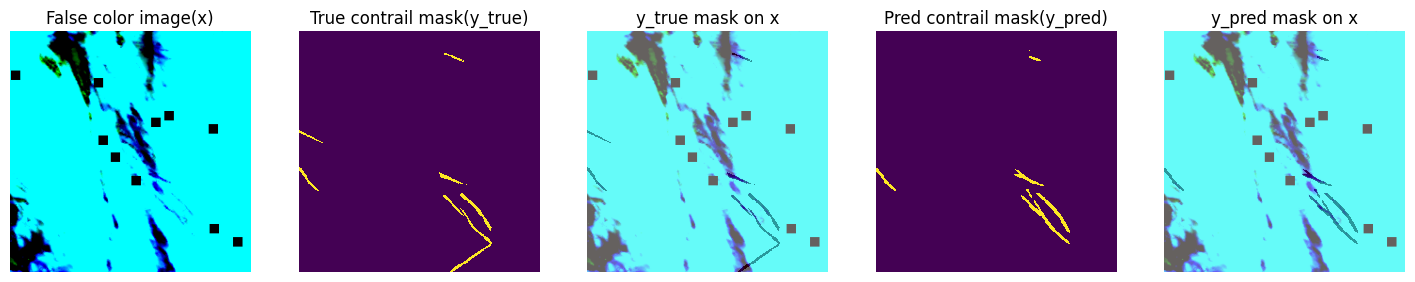

Val Batch: 1/116 | GlobalDICELoss: 0.369539
Val Batch: 101/116 | GlobalDICELoss: 0.409084


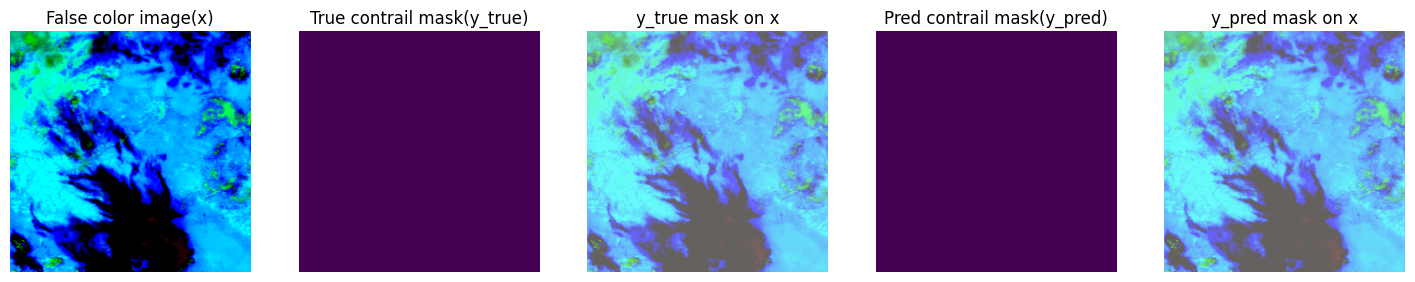

Loss: Train = 0.050883         | Val = 0.446997
Dice: Train = 0.762137         | Val = 0.789703
EPOCH: 6/10, Learning rate: 3.125e-05
Train Batch: 1/1283 | Loss: 0.051670
FOCAL_Loss: 0.026809
LogCoshDICE_Loss: 0.057885
Train Batch: 101/1283 | Loss: 0.073616
FOCAL_Loss: 0.029613
LogCoshDICE_Loss: 0.084616
Train Batch: 201/1283 | Loss: 0.051398
FOCAL_Loss: 0.016932
LogCoshDICE_Loss: 0.060014
Train Batch: 301/1283 | Loss: 0.050660
FOCAL_Loss: 0.020900
LogCoshDICE_Loss: 0.058099
Train Batch: 401/1283 | Loss: 0.041931
FOCAL_Loss: 0.021029
LogCoshDICE_Loss: 0.047157
Train Batch: 501/1283 | Loss: 0.056809
FOCAL_Loss: 0.012167
LogCoshDICE_Loss: 0.067969
Train Batch: 601/1283 | Loss: 0.038903
FOCAL_Loss: 0.014791
LogCoshDICE_Loss: 0.044931
Train Batch: 701/1283 | Loss: 0.029559
FOCAL_Loss: 0.008638
LogCoshDICE_Loss: 0.034790
Train Batch: 801/1283 | Loss: 0.061058
FOCAL_Loss: 0.042150
LogCoshDICE_Loss: 0.065785
Train Batch: 901/1283 | Loss: 0.048840
FOCAL_Loss: 0.021828
LogCoshDICE_Loss: 0.05559

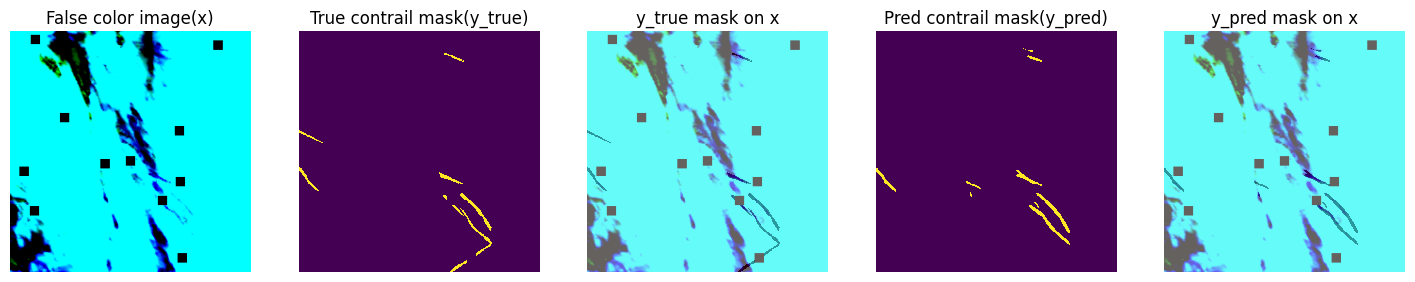

Val Batch: 1/116 | GlobalDICELoss: 0.366371
Val Batch: 101/116 | GlobalDICELoss: 0.383325


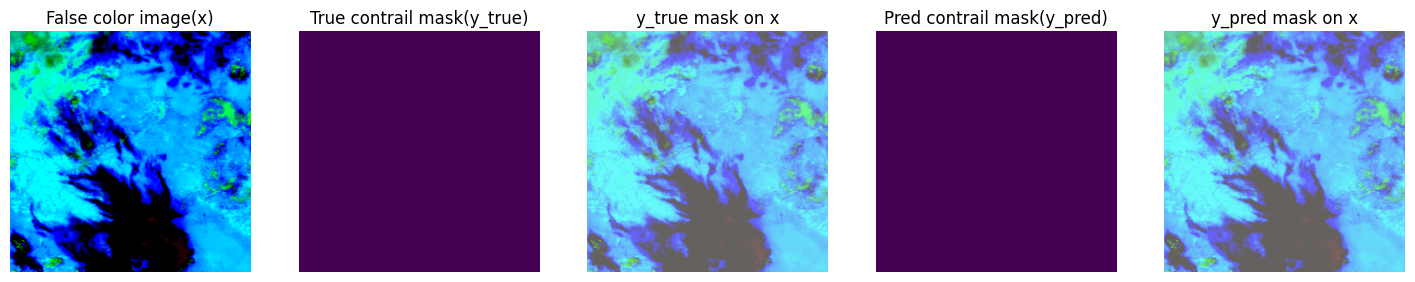

Loss: Train = 0.050453         | Val = 0.446379
Dice: Train = 0.763882         | Val = 0.789084
EPOCH: 7/10, Learning rate: 3.125e-05
Train Batch: 1/1283 | Loss: 0.052490
FOCAL_Loss: 0.024720
LogCoshDICE_Loss: 0.059433
Train Batch: 101/1283 | Loss: 0.070905
FOCAL_Loss: 0.025030
LogCoshDICE_Loss: 0.082374
Train Batch: 201/1283 | Loss: 0.052791
FOCAL_Loss: 0.017957
LogCoshDICE_Loss: 0.061499
Train Batch: 301/1283 | Loss: 0.049924
FOCAL_Loss: 0.021960
LogCoshDICE_Loss: 0.056915
Train Batch: 401/1283 | Loss: 0.044149
FOCAL_Loss: 0.021786
LogCoshDICE_Loss: 0.049740
Train Batch: 501/1283 | Loss: 0.051070
FOCAL_Loss: 0.011517
LogCoshDICE_Loss: 0.060958
Train Batch: 601/1283 | Loss: 0.040835
FOCAL_Loss: 0.014998
LogCoshDICE_Loss: 0.047294
Train Batch: 701/1283 | Loss: 0.033160
FOCAL_Loss: 0.009386
LogCoshDICE_Loss: 0.039103
Train Batch: 801/1283 | Loss: 0.059718
FOCAL_Loss: 0.040739
LogCoshDICE_Loss: 0.064463
Train Batch: 901/1283 | Loss: 0.053375
FOCAL_Loss: 0.021087
LogCoshDICE_Loss: 0.06144

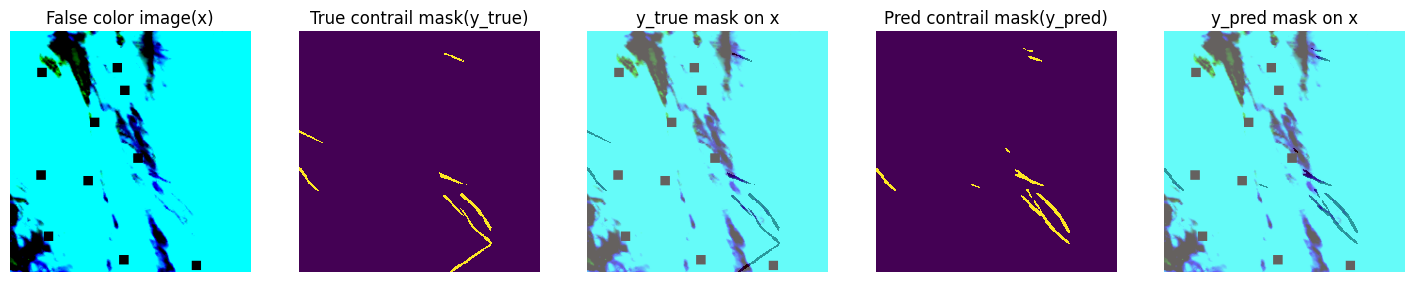

Val Batch: 1/116 | GlobalDICELoss: 0.372049
Val Batch: 101/116 | GlobalDICELoss: 0.431417


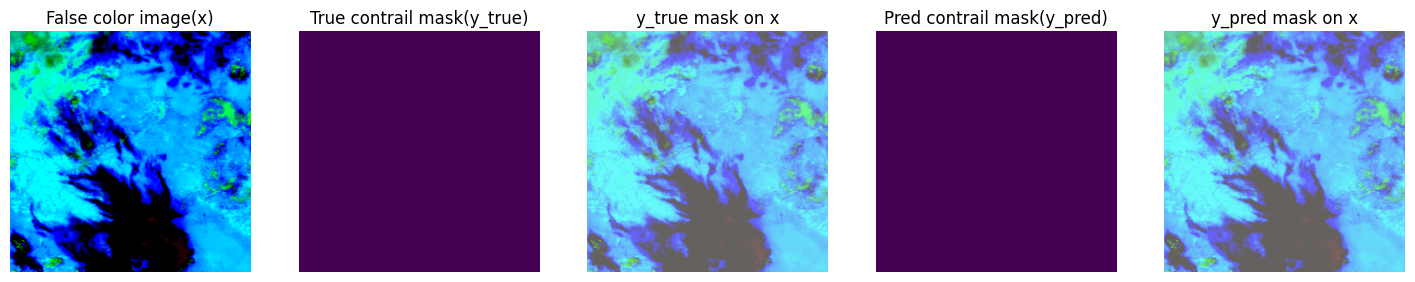

Loss: Train = 0.049996         | Val = 0.446048
Dice: Train = 0.764505         | Val = 0.788931
EPOCH: 8/10, Learning rate: 7.8125e-06
Train Batch: 1/1283 | Loss: 0.047710
FOCAL_Loss: 0.026316
LogCoshDICE_Loss: 0.053058
Train Batch: 101/1283 | Loss: 0.067442
FOCAL_Loss: 0.028691
LogCoshDICE_Loss: 0.077129
Train Batch: 201/1283 | Loss: 0.050563
FOCAL_Loss: 0.017285
LogCoshDICE_Loss: 0.058882
Train Batch: 301/1283 | Loss: 0.049899
FOCAL_Loss: 0.020537
LogCoshDICE_Loss: 0.057239
Train Batch: 401/1283 | Loss: 0.042424
FOCAL_Loss: 0.021048
LogCoshDICE_Loss: 0.047768
Train Batch: 501/1283 | Loss: 0.054916
FOCAL_Loss: 0.012136
LogCoshDICE_Loss: 0.065611
Train Batch: 601/1283 | Loss: 0.036981
FOCAL_Loss: 0.014321
LogCoshDICE_Loss: 0.042646
Train Batch: 701/1283 | Loss: 0.029334
FOCAL_Loss: 0.008508
LogCoshDICE_Loss: 0.034540
Train Batch: 801/1283 | Loss: 0.061080
FOCAL_Loss: 0.042171
LogCoshDICE_Loss: 0.065807
Train Batch: 901/1283 | Loss: 0.046131
FOCAL_Loss: 0.020160
LogCoshDICE_Loss: 0.0526

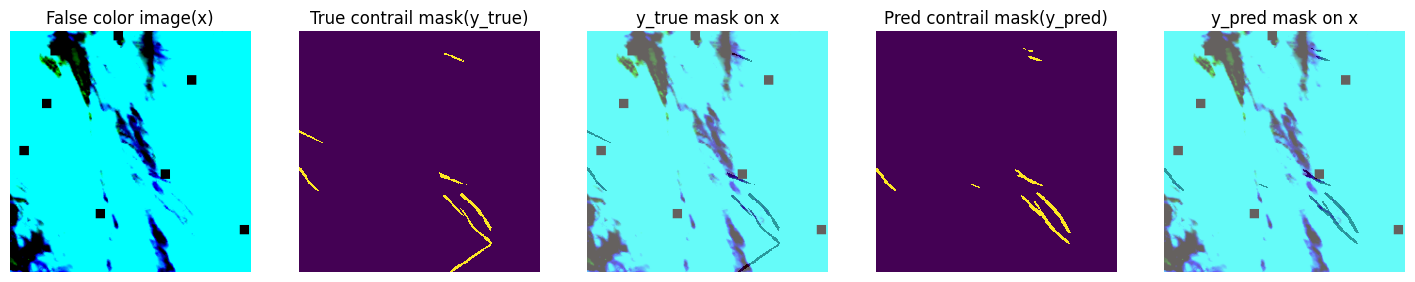

Val Batch: 1/116 | GlobalDICELoss: 0.376580
Val Batch: 101/116 | GlobalDICELoss: 0.430775


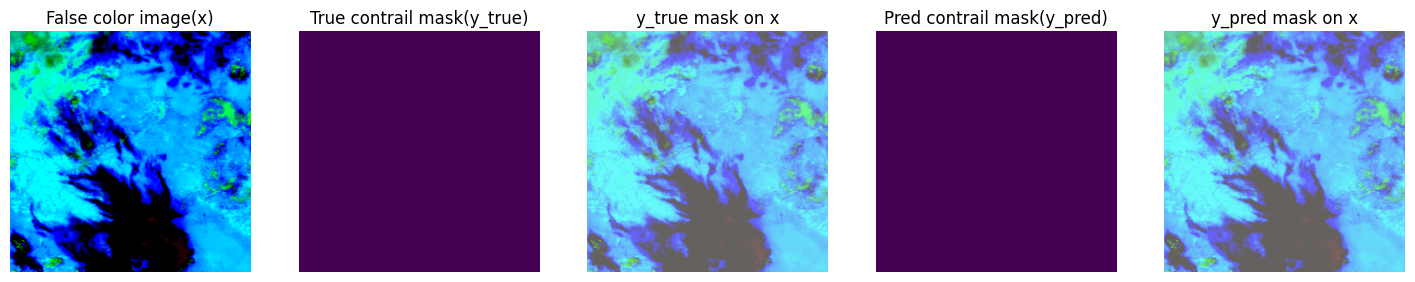

Loss: Train = 0.050289         | Val = 0.446369
Dice: Train = 0.765300         | Val = 0.792423
EPOCH: 9/10, Learning rate: 7.8125e-06
Train Batch: 1/1283 | Loss: 0.053350
FOCAL_Loss: 0.024627
LogCoshDICE_Loss: 0.060531
Train Batch: 101/1283 | Loss: 0.081956
FOCAL_Loss: 0.029621
LogCoshDICE_Loss: 0.095040
Train Batch: 201/1283 | Loss: 0.048697
FOCAL_Loss: 0.016535
LogCoshDICE_Loss: 0.056738
Train Batch: 301/1283 | Loss: 0.047559
FOCAL_Loss: 0.020342
LogCoshDICE_Loss: 0.054364
Train Batch: 401/1283 | Loss: 0.039760
FOCAL_Loss: 0.020187
LogCoshDICE_Loss: 0.044653
Train Batch: 501/1283 | Loss: 0.052502
FOCAL_Loss: 0.011784
LogCoshDICE_Loss: 0.062681
Train Batch: 601/1283 | Loss: 0.039647
FOCAL_Loss: 0.015033
LogCoshDICE_Loss: 0.045800
Train Batch: 701/1283 | Loss: 0.029044
FOCAL_Loss: 0.008859
LogCoshDICE_Loss: 0.034090
Train Batch: 801/1283 | Loss: 0.062733
FOCAL_Loss: 0.041531
LogCoshDICE_Loss: 0.068034
Train Batch: 901/1283 | Loss: 0.046753
FOCAL_Loss: 0.020052
LogCoshDICE_Loss: 0.0534

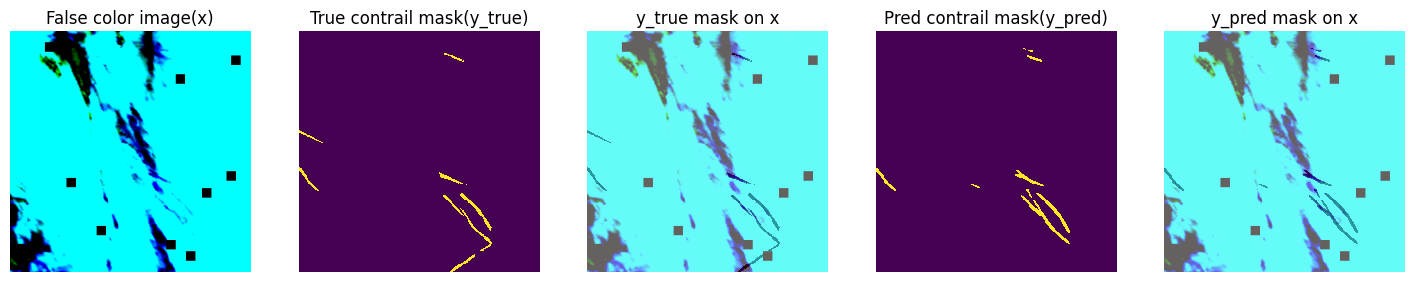

Val Batch: 1/116 | GlobalDICELoss: 0.374147
Val Batch: 101/116 | GlobalDICELoss: 0.420013


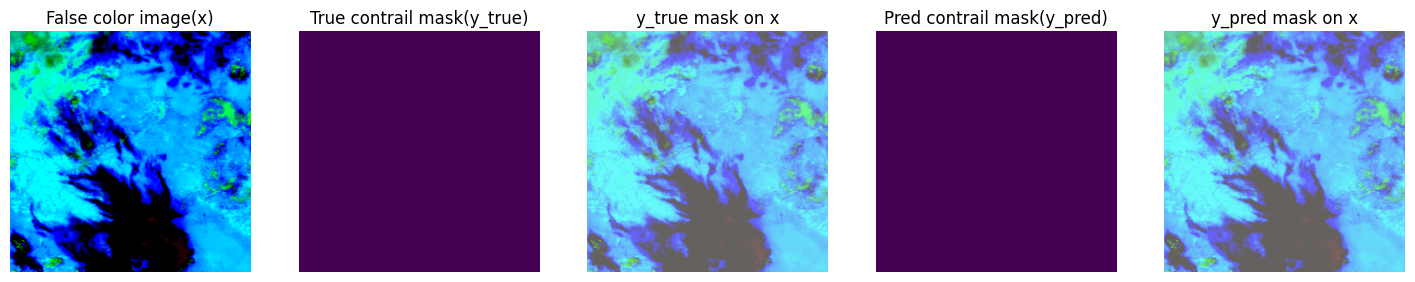

Loss: Train = 0.050165         | Val = 0.446063
Dice: Train = 0.763366         | Val = 0.791995
EPOCH: 10/10, Learning rate: 7.8125e-06
Train Batch: 1/1283 | Loss: 0.048308
FOCAL_Loss: 0.025409
LogCoshDICE_Loss: 0.054033
Train Batch: 101/1283 | Loss: 0.068204
FOCAL_Loss: 0.026687
LogCoshDICE_Loss: 0.078583
Train Batch: 201/1283 | Loss: 0.052533
FOCAL_Loss: 0.017557
LogCoshDICE_Loss: 0.061277
Train Batch: 301/1283 | Loss: 0.047977
FOCAL_Loss: 0.020391
LogCoshDICE_Loss: 0.054873
Train Batch: 401/1283 | Loss: 0.042317
FOCAL_Loss: 0.021287
LogCoshDICE_Loss: 0.047574
Train Batch: 501/1283 | Loss: 0.051417
FOCAL_Loss: 0.011575
LogCoshDICE_Loss: 0.061377
Train Batch: 601/1283 | Loss: 0.037472
FOCAL_Loss: 0.014339
LogCoshDICE_Loss: 0.043255
Train Batch: 701/1283 | Loss: 0.029016
FOCAL_Loss: 0.008775
LogCoshDICE_Loss: 0.034076
Train Batch: 801/1283 | Loss: 0.060975
FOCAL_Loss: 0.042483
LogCoshDICE_Loss: 0.065598
Train Batch: 901/1283 | Loss: 0.049560
FOCAL_Loss: 0.022830
LogCoshDICE_Loss: 0.056

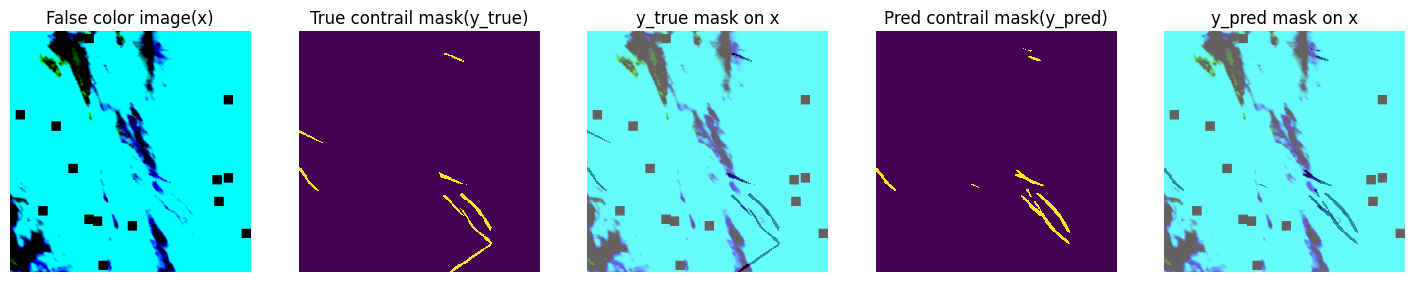

Val Batch: 1/116 | GlobalDICELoss: 0.370861
Val Batch: 101/116 | GlobalDICELoss: 0.413667


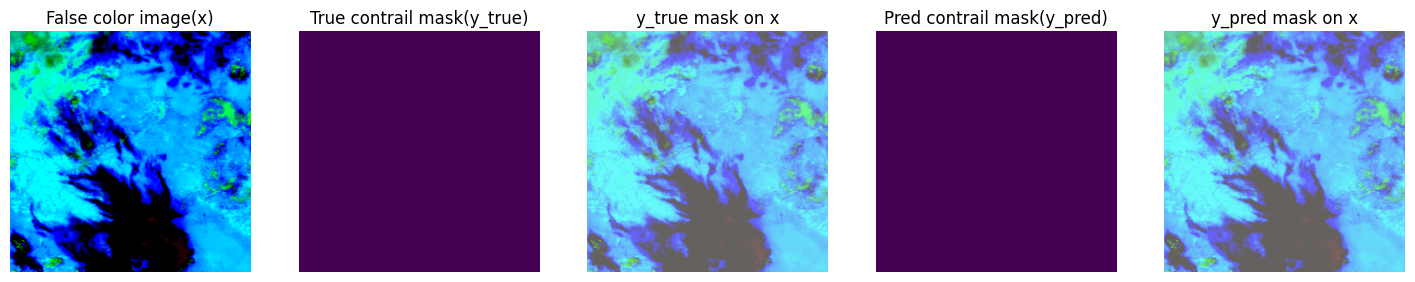

Loss: Train = 0.050140         | Val = 0.446325
Dice: Train = 0.764622         | Val = 0.792889


  0%|          | 0/10 [3:19:52<?, ?it/s]


In [29]:
xmp.spawn(_map_fn, args=(FLAGS,), nprocs=1, start_method='fork')